<a href="https://colab.research.google.com/github/andrinur13/kuliah_bigdata/blob/master/1800018190.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Perbandingan Rata-Rata Biaya Asuransi Kesehatan (Insurance) Berdasarkan Jenis Kelamin dan Perilaku Merokok**

Nama  : Andri Nur Hidayatulloh

NIM   : 1800018190 

### **Persiapan Environtment**

Instalasi java jdk dan pyspark

Instalasi package findspark dan pyspark_dist_explore.

In [ ]:
! apt-get install openjdk-8-jdk-headless -qq > /dev/null
! wget -q https://downloads.apache.org/spark/spark-2.4.6/spark-2.4.6-bin-hadoop2.7.tgz
! tar xf spark-2.4.6-bin-hadoop2.7.tgz
! pip install -q findspark
! pip install pyspark_dist_explore

Import package OS dan set environtment Java

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

import package yang akan digunakan

In [3]:
import findspark
findspark.init("spark-2.4.6-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark.sql.functions import col, avg
from matplotlib import pyplot as plt
from pyspark_dist_explore import Histogram, hist

Inisialisasi SparkContext dan SparkSession

In [4]:
sc = spark.sparkContext
spark = SparkSession(sc)

### **Load Dataset**

In [5]:
data = spark.read.csv('insurance.csv', header=True, inferSchema=True)
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



Pada dataset insurances tersebut terdapat 7 kolom data yaitu : 



1.   Age (Umur dari pengguna asuransi kesehatan)
2.   Sex (Jenis kelamin dari pengguna asuransi)
3.   BMI (Index masa tubuh)
4.   Children (Jumlah Anak)
5.   Smoker (perilaku pengguna asuransi apakah merokok atau tidak)
6.   Region (alamat pengguna asuransi)
7.   Charges (biaya asuransi)

Pada kasus kali ini akan dianalisis pada kolom Sex, Smoker dan Charges



## **1. Proses EDA**

Total Data Pengguna Asuransi

In [6]:
print("Total Pengguna Asuransi : ", data.count())

Total Pengguna Asuransi :  1338


Lihat 5 data teratas pada data tersebut

In [7]:
data.show(5)

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
+---+------+------+--------+------+---------+-----------+
only showing top 5 rows



**Statistik dataset pengguna asuransi kesehatan**

In [8]:
data.describe().show()

+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|summary|               age|   sex|               bmi|         children|smoker|   region|           charges|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|  count|              1338|  1338|              1338|             1338|  1338|     1338|              1338|
|   mean| 39.20702541106129|  null|30.663396860986538|  1.0949177877429|  null|     null|13270.422265141257|
| stddev|14.049960379216147|  null| 6.098186911679012|1.205492739781914|  null|     null|12110.011236693992|
|    min|                18|female|             15.96|                0|    no|northeast|         1121.8739|
|    max|                64|  male|             53.13|                5|   yes|southwest|       63770.42801|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+



Statistik data : 

pada colom sex, smoker dan region memiliki nilai mean, standar deviasi **null**. Hal ini dikarenakan data tersebut bukan berisi angka namun berisi string, oleh sebab itu menghasilkan null karena string tidak dapat dikalkukasi dalam proses mean dan sttdev

**Persebaran Data pada kolom charges**

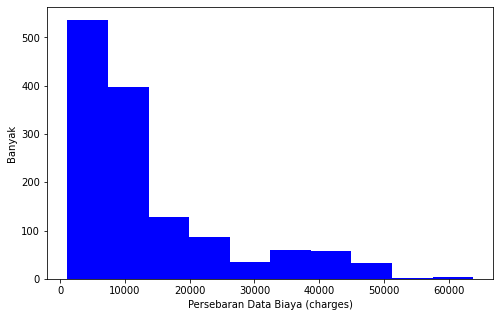

In [10]:
data_charges = data.select('charges')

fig, axes = plt.subplots()
fig.set_size_inches(8, 5)
hist(axes, data_charges, color="blue")
plt.xlabel('Persebaran Data Biaya (charges)')
plt.ylabel('Banyak')

plt.show()

Pada data persebaran **biaya asuransi (charges)** tidak terdapat outlier, dan biaya terkecil asuransi tersebut adalah 1121.8739 dan biaya terbesar asuransi tersebut adalah 63770.42801 

**Cek apakah adat data yang kosong (null)**

In [11]:
table = ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

for kolom in table:
  print('jumlah data yang bernilai null pada colom ', kolom, ' : ', data.where(col(kolom).isNull()).count())

jumlah data yang bernilai null pada colom  age  :  0
jumlah data yang bernilai null pada colom  sex  :  0
jumlah data yang bernilai null pada colom  bmi  :  0
jumlah data yang bernilai null pada colom  children  :  0
jumlah data yang bernilai null pada colom  smoker  :  0
jumlah data yang bernilai null pada colom  region  :  0
jumlah data yang bernilai null pada colom  charges  :  0


Pada dataset tersebut tidak terdapat data yang kosong/null.

## **2. PRE PROCESSING**

Karena tidak ada data yang null, maka data tersebut sudah siap untuk diproses.

Namun, data tersebut akan difilter / seleksi pada kolom yang dibutuhkan saja.

Pada data tersebut kita butuh kolom sex, smoker dan charges

In [12]:
# seleksi data
dataDF = data.select('sex', 'smoker', 'charges')

# tampilkan 10 data teratas
dataDF.show(10)

+------+------+-----------+
|   sex|smoker|    charges|
+------+------+-----------+
|female|   yes|  16884.924|
|  male|    no|  1725.5523|
|  male|    no|   4449.462|
|  male|    no|21984.47061|
|  male|    no|  3866.8552|
|female|    no|  3756.6216|
|female|    no|  8240.5896|
|female|    no|  7281.5056|
|  male|    no|  6406.4107|
|female|    no|28923.13692|
+------+------+-----------+
only showing top 10 rows



## **3. PEMROSESAN DATA**

Pada pemrosesan data ini akan dianalisis perbandingan rata-rata biaya asuransi kesehatan berdasarkan jenis kelamin dan perilaku merokok

**3.1 Perbandingan rata-rata biaya asuransi kesehatan berdasarkan jenis kelamin**

Pada pemrosesan rata-rata biaya asuransi kesehatan berdasarkan jenis kelamin menggunakan transformation dan action pada spark dataframe

In [13]:
# pada pemrosesan data ini menggunakan transformasi dan action pada spark dataframe

# seleksi data perempuan
data_perempuan = dataDF.filter(dataDF.sex == 'female')

# seleksi data laki-laki
data_lakiLaki = dataDF.filter(dataDF.sex == 'male')

# hitung rata-rata biaya asuransi kesehatan berdasarkan jenis kelamin
rata_rata_biaya_jk = dataDF.groupBy('sex').avg('charges')

# output
print("Jumlah pengguna asuransi perempuan   : ", data_perempuan.count())
print("Jumlah pengguna asuransi laki-laki   : ", data_lakiLaki.count())

print('\n')

# 5 data teratas pengguna asuransi perempuan
print('5 data teratas pengguna asuransi berjenis kelamin perempuan')
data_perempuan.show(5)

print('\n')

print('5 data teratas pengguna asuransi berjenis kelamin laki-laki')
data_lakiLaki.show(5)

print('\n')

print('Perbandingan biaya asuransi kesehatan berdasarkan jenis kelamin')
rata_rata_biaya_jk.show()

# ambil data single value dari spark sql
rata_biaya_pr = rata_rata_biaya_jk.collect()[0][1]
rata_biaya_lk = rata_rata_biaya_jk.collect()[1][1]

Jumlah pengguna asuransi perempuan   :  662
Jumlah pengguna asuransi laki-laki   :  676


5 data teratas pengguna asuransi berjenis kelamin perempuan
+------+------+-----------+
|   sex|smoker|    charges|
+------+------+-----------+
|female|   yes|  16884.924|
|female|    no|  3756.6216|
|female|    no|  8240.5896|
|female|    no|  7281.5056|
|female|    no|28923.13692|
+------+------+-----------+
only showing top 5 rows



5 data teratas pengguna asuransi berjenis kelamin laki-laki
+----+------+-----------+
| sex|smoker|    charges|
+----+------+-----------+
|male|    no|  1725.5523|
|male|    no|   4449.462|
|male|    no|21984.47061|
|male|    no|  3866.8552|
|male|    no|  6406.4107|
+----+------+-----------+
only showing top 5 rows



Perbandingan biaya asuransi kesehatan berdasarkan jenis kelamin
+------+------------------+
|   sex|      avg(charges)|
+------+------------------+
|female| 12569.57884383534|
|  male|13956.751177721886|
+------+------------------+



Pada data tersebut telah dilakukan pemrosesan data berupa seleksi pengguna asuransi kesehatan berdasarkan jenis kelamin, yaitu laki-laki dan perempuan. Hasil tersebut didapat banyak pengguna asuransi kesehatan berjenis kelamin perempuan sebanyak **662** dan pengguna asuransi kesehatan berjenis kelamin laki-laki sebanyak **676**.

Lalu dilakukan pemrosesan data berupa perhitungan rata-rata biaya asuransi kesehatan berdasarkan jenis kelamin. Didapat hasil rata-rata biaya asuransi kesehatan perempuan adalah : **12569.57884383534**, sedangkan untuk laki-laki adalah : **13956.751177721886**

**3.2 Perbandingan rata-rata biaya asuransi kesehatan berdasarkan perilaku merokok**

Pada pemrosesan rata-rata biaya asuransi kesehatan berdasarkan perilaku merokok menggunakan pemrosesan spark dataframe

In [14]:
# pada pemrosesan data ini menggunakan transformasi dan action pada spark dataframe

# filter data pengguna asuransi yang merokok
data_perokok = dataDF.filter(dataDF.smoker == 'yes')

# filter data pengguna asuransi yang tidak merokok
data_tidak_perokok = dataDF.filter(dataDF.smoker == 'no')

# hitung rata-rata biaya asuransi kesehatan berdasarkan perilaku merokok
rata_rata_biaya_pmrk = dataDF.groupBy('smoker').avg('charges')

# ambil single value dari spark datframe
rata_biaya_jika_tidak_perokok = rata_rata_biaya_pmrk.collect()[0][1]
rata_biaya_jika_perokok = rata_rata_biaya_pmrk.collect()[1][1]

# output
print('Jumlah pengguna asuransi kesehatan yang merokok       : ', data_perokok.count())
print('Jumlah pengguna asuransi kesehatan yang tidak merokok : ', data_tidak_perokok.count())

print('\n')

print('5 data teratas pengguna asuransi yang merokok')
data_perokok.show(5)

print('5 data teratas pengguna asuransi kesehatan yang tidak merokok')
data_tidak_perokok.show(5)

print('Rata rata perbandingan biaya asuransi kesehatan berdasarkan perilaku merokok')
rata_rata_biaya_pmrk.show()

Jumlah pengguna asuransi kesehatan yang merokok       :  274
Jumlah pengguna asuransi kesehatan yang tidak merokok :  1064


5 data teratas pengguna asuransi yang merokok
+------+------+----------+
|   sex|smoker|   charges|
+------+------+----------+
|female|   yes| 16884.924|
|female|   yes|27808.7251|
|  male|   yes|39611.7577|
|  male|   yes| 36837.467|
|female|   yes|37701.8768|
+------+------+----------+
only showing top 5 rows

5 data teratas pengguna asuransi kesehatan yang tidak merokok
+------+------+-----------+
|   sex|smoker|    charges|
+------+------+-----------+
|  male|    no|  1725.5523|
|  male|    no|   4449.462|
|  male|    no|21984.47061|
|  male|    no|  3866.8552|
|female|    no|  3756.6216|
+------+------+-----------+
only showing top 5 rows

Rata rata perbandingan biaya asuransi kesehatan berdasarkan perilaku merokok
+------+-----------------+
|smoker|     avg(charges)|
+------+-----------------+
|    no|8434.268297856199|
|   yes|32050.23183153285|
+------+--

Pada data tersebut telah dilakukan pemrosesan data berupa seleksi pengguna asuransi kesehatan berdasarkan perilaku merokok. Hasil tersebut didapat banyak pengguna asuransi kesehatan yang merokok sebanyak **274** dan pengguna asuransi kesehatan yang tidak merokok sebanyak **1064**.

Lalu dilakukan pemrosesan data berupa perhitungan rata-rata biaya asuransi kesehatan berdasarkan perilaku merokok. Didapat hasil rata-rata biaya asuransi kesehatan untuk orang yang merokok adalah : **32050.23183153285**, sedangkan untuk orang yang tidak merokok adalah : 32050.23183153285

**3.3 Perbandingan rata-rata biaya asuransi kesehatan berdasarkan jenis kelamin dan perilaku merokok**

In [15]:
# pada pemrosesan data ini menggunakan transformasi dan action pada spark dataframe

# filter pengguna asuransi perempuan yang merokok
data_perempuan_perokok = data_perempuan.filter(data_perempuan['smoker'] == 'yes')

# filter pengguna asuransi perempuan yang tidak merokok
data_perempuan_tidak_perokok = data_perempuan.filter(data_perempuan['smoker'] == 'no')

# filter pengguna asuransi laki-laki yang merokok
data_lakiLaki_perokok = data_lakiLaki.filter(data_lakiLaki['smoker'] == 'yes')

# filter pengguna asuransi laki-laki yang tidak merokok
data_lakiLaki_tidak_perokok = data_lakiLaki.filter(data_lakiLaki['smoker'] == 'no')

# hitung rata-rata biaya asuransi kesehatan
rata_biaya_berdasarkan_jk_dan_perokok = dataDF.groupby('sex', 'smoker').avg('charges')

# ambil single value dari dataframe
pr_mrkk = rata_biaya_berdasarkan_jk_dan_perokok.collect()[2][2]
pr_tdk_mrkk = rata_biaya_berdasarkan_jk_dan_perokok.collect()[3][2]
lk_mrkk = rata_biaya_berdasarkan_jk_dan_perokok.collect()[1][2]
lk_tdk_mrkk = rata_biaya_berdasarkan_jk_dan_perokok.collect()[0][2]

# output

print('Perempuan merokok sebanyak          : ', data_perempuan_perokok.count())
print('Perempuan tidak merokok sebanyak    : ', data_perempuan_tidak_perokok.count())
print('Laki-laki merokok sebanyak          : ', data_lakiLaki_perokok.count())
print('Laki-laki tidak merokok sebanyak    : ', data_lakiLaki_tidak_perokok.count())

print('\n Rata-rata biaya asuransi kesehatan')

rata_biaya_berdasarkan_jk_dan_perokok.show()

Perempuan merokok sebanyak          :  115
Perempuan tidak merokok sebanyak    :  547
Laki-laki merokok sebanyak          :  159
Laki-laki tidak merokok sebanyak    :  517

 Rata-rata biaya asuransi kesehatan
+------+------+------------------+
|   sex|smoker|      avg(charges)|
+------+------+------------------+
|  male|    no| 8087.204731276592|
|  male|   yes| 33042.00597528302|
|female|   yes|30678.996276260867|
|female|    no| 8762.297299541116|
+------+------+------------------+



## **4. VISUALISASI DATA**

visualisasi data kali ini menggunakan library matplotlib, menggunakan grafis bar.

Data yang akan divisulisasi yaitu rata-rata biaya asuransi kesehatan berdasarkan jenis kelamin, berdasarkan perilaku merokok dan keduanya.

**4.1 Rata rata biaya asuransi berdasarkan jenis kelamin**

Jumlah pengguna asuransi berdasarkan jenis kelamin

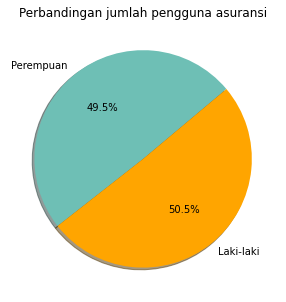

In [16]:
# plotting data
fig, axes = plt.subplots()

# jumlah pengguna asuransi laki-laki dan perempuan
fig.set_size_inches(7, 5)

plt.title('Perbandingan jumlah pengguna asuransi')
plt.pie([data_perempuan.count(), data_lakiLaki.count()], labels=['Perempuan', 'Laki-laki'], autopct='%1.1f%%', shadow=True, startangle=40, colors=['#6ebfb5', 'orange'])
print('\n')

Perbandingan rata-rata biaya asuransi kesehatan berdasarkan jenis kelamin

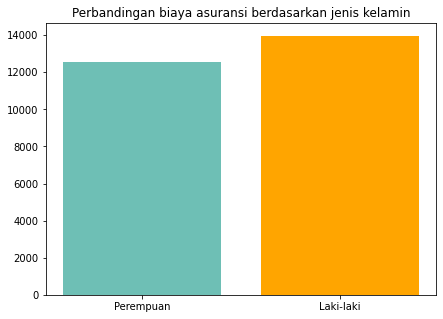

In [17]:
# perbandingan biaya asuransi berdasarkan jenis kelamin
fig, axes = plt.subplots()

fig.set_size_inches(7, 5)
plt.title('Perbandingan biaya asuransi berdasarkan jenis kelamin')
plt.bar('Perempuan', rata_biaya_pr, color='#6ebfb5')
plt.bar('Laki-laki', rata_biaya_lk, color='orange')
print('\n')

Didapat sebuah kesimpulan, dari data tersebut mengatakan bahwa biaya asuransi kesehatan yang dibayarkan berdasarkan jenis kelamin, laki-laki memiliki biaya yang harus dibayarkan lebih tinggi dari pada biaya asuransi yang dibayarkan oleh perempuan

**4.2 Rata rata biaya asuransi berdasarkan perilaku merokok**

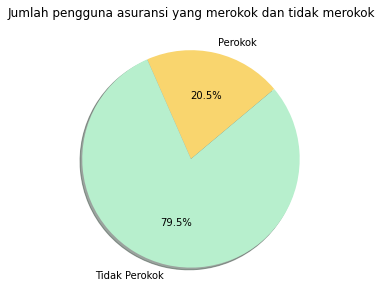

In [18]:
# plotting data
fig, axes = plt.subplots()

# jumlah pengguna asuransi laki-laki dan perempuan
fig.set_size_inches(7, 5)

plt.title('Jumlah pengguna asuransi yang merokok dan tidak merokok')
plt.pie([data_perokok.count(), data_tidak_perokok.count()], labels=['Perokok', 'Tidak Perokok'], autopct='%1.1f%%', shadow=True, startangle=40, colors=['#f9d56e', '#b7efcd'])
print('\n')

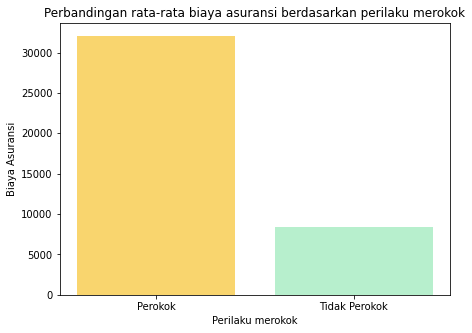

In [19]:
# plotting data 

# rata-rata biaya asuransi kesehatan berdasarkan perilaku merokok
# rata_rata_biaya_pr.collect()
fig, axes = plt.subplots()

plt.title('Perbandingan rata-rata biaya asuransi berdasarkan perilaku merokok')
plt.bar('Perokok', rata_biaya_jika_perokok, color='#f9d56e')
plt.bar('Tidak Perokok', rata_biaya_jika_tidak_perokok, color='#b7efcd')
plt.xlabel('Perilaku merokok')
plt.ylabel('Biaya Asuransi')
fig.set_size_inches(7, 5)

print('\n')

Didapat sebuah kesimpulan, dari data tersebut biaya asuransi yang harus dibayarkan berdasarkan perilaku merokok yaitu, orang yang memiliki perilaku merokok memiliki beban biaya asuransi kesehatan lebih tinggi daripada orang yang tidak merokok

**4.3 Rata rata biaya asuransi berdasarkan jenis kelamin dan perilaku merokok**

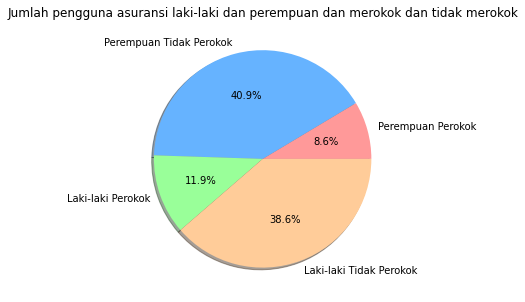

In [20]:
# plotting data
fig, axes = plt.subplots()

# jumlah pengguna asuransi laki-laki dan perempuan
fig.set_size_inches(7, 5)

plt.title('Jumlah pengguna asuransi laki-laki dan perempuan dan merokok dan tidak merokok')
plt.pie([data_perempuan_perokok.count(), data_perempuan_tidak_perokok.count(), data_lakiLaki_perokok.count(), data_lakiLaki_tidak_perokok.count()], labels=['Perempuan Perokok', 'Perempuan Tidak Perokok', 'Laki-laki Perokok', 'Laki-laki Tidak Perokok'], autopct='%1.1f%%', shadow=True, startangle=0, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
print('\n')

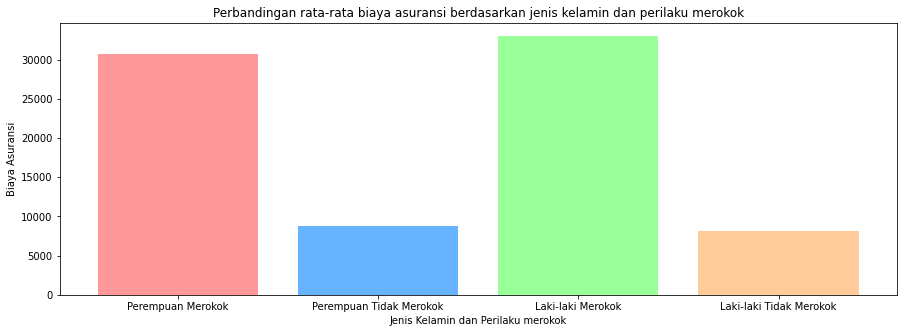

In [21]:
# plotting data 

# rata-rata biaya asuransi kesehatan berdasarkan jenis kelamin perilaku merokok
fig, axes = plt.subplots()

plt.title('Perbandingan rata-rata biaya asuransi berdasarkan jenis kelamin dan perilaku merokok')
plt.bar('Perempuan Merokok', pr_mrkk, color='#ff9999')
plt.bar('Perempuan Tidak Merokok', pr_tdk_mrkk, color='#66b3ff')
plt.bar('Laki-laki Merokok', lk_mrkk, color='#99ff99')
plt.bar('Laki-laki Tidak Merokok', lk_tdk_mrkk, color='#ffcc99')
plt.xlabel('Jenis Kelamin dan Perilaku merokok')
plt.ylabel('Biaya Asuransi')
fig.set_size_inches(15, 5)

print('\n')

Didapat sebuah kesimpulan, dari data tersebut mengatakan bahwa laki-laki yang merokok menanggung beban asuransi kesehatan lebih tinggi dari pada perempuan yang merokok yang menempati posisi kedua tertinggi, selanjutnya perempuan tidak merokok dan laki-laki tidak merokok



Namun didapat sebuah kesimpulan bersama bahwa orang yang merokok memiliki beban biaya asuransi kesehatan yang cukup tinggi, hal ini terbukti dari grafik yang disajikan

In [22]:
spark.stop() #stop spark